In [1]:
import sys

import numpy as np
import pandas as pd
import scipy.linalg as spla

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import networkx as nx

sys.path.append("../../../code/ndsvae/")
import ndsvae as ndsv

sys.path.append("..")
import util
import plotutils as pu

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
! ls ../run/hcp/hcp_linw_dicer/modelAN/ns_3_mreg_2_msub_1_nf_32/run00/

fit  parameters.npz  simulations.npz


In [3]:
config = "ns_3_mreg_3_msub_2_nf_32"
preproc = "dicer"
conn = "linw"
modelname = "AB"

run = util.select_run(f"hcp_{conn}_{preproc}", modelname, config, [0,1], "hcp")

In [4]:
run

0

In [5]:
ds = ndsv.Dataset.from_file(f"../run/hcp/hcp_{conn}_{preproc}/dataset.npz")

In [6]:
nsub, nreg, _, nt = ds.y.shape
warmup = nt // 4

In [7]:
import tensorflow as tf

In [8]:
model = util.get_model(modelname, config, ds)
# model.load_weights(os.path.join(fit_direc, "model"))
model.load_weights(f"../run/hcp/hcp_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}/fit/model")

In [9]:
params = ndsv.Params.from_file(
    f"../run/hcp/hcp_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}/parameters.npz")

## Parameter order

In [14]:
def calc_kl_sub(tsub, nsamples=10):
    nsub, msub, _ = tsub.shape
        
    kl = np.full((nsub, msub), np.nan)
    
    msub = tsub.shape[1]

    tsubmu  = tsub[:,:,0]
    tsubstd = tsub[:,:,1]
   
    tsub_samples = np.random.normal(tsubmu[:,:,None], tsubstd[:,:,None], size=(nsub, msub, nsamples))
    tsub2mu  = np.mean(np.reshape(tsub_samples, (msub, nsub*nsamples)), axis=1)
    tsub2std = np.std(np.reshape(tsub_samples, (msub, nsub*nsamples)), axis=1)
    
    for i in range(msub):
        kl[:,i] = (np.log(tsub2std[i]/tsubstd[:,i]) 
                   + (tsubstd[:,i]**2 + (tsubmu[:,i] - tsub2mu[i])**2)/(2*tsub2std[i]**2) - 0.5)
    
    
    return np.mean(kl, axis=0)

In [15]:
np.random.seed(42)
order = np.argsort(-calc_kl_sub(params.thetasub, nsamples=10)) 

### Simulation

In [31]:
def simulate(w, x0, us, treg, tsub):
    w = w[None,:,:]
    x0 = x0[None,None,:,:]
    us = us[None,None,:]
    treg = treg[None,None,:,:]
    tsub = tsub[None,None,:]
    x, y = model.source_model.simulate_subjects(w, nt, x0, us, treg, tsub, model.Ap.numpy(),
                                                model.bp.numpy(), model.olv)
    
    return y[0,0,:,0,:]

def param_sweep(iparam):
    np.random.seed(42)
    isub = 0
    n = 5
    msub = 2

    ns = model.ns
    mreg = model.mreg

    w = ds.w[isub]
    x0 = np.zeros((nreg, ns))

    t = np.linspace(0,1200,1200)
    # us = np.zeros(nt)
    # us = 1*np.sin(0.2*t/(2*np.pi))
    us = np.random.normal(params.us[isub,:,0], params.us[isub,:,1])
    treg = np.random.normal(0, 1, size=(nreg,mreg))
    tsubs = np.zeros((n, msub))
    tsubs[:,iparam] = np.linspace(-0.8,0.8,n)
    
    y = np.zeros((n, nreg, nt))
    for i, tsub in enumerate(tsubs):
        np.random.seed(42)    
        y[i] = simulate(w, x0, us, treg, tsub)
        
    return y, us, tsubs

## Plot it!

In [32]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [33]:
def plot_input(ax, us, dt=1):
    plt.plot(us, color='k', lw=0.5)    
    plt.xlim(0, 1200)
    plt.ylim(-3.2,3.2)
    plt.yticks([0], ["Input"])
    
    plt.xticks([])    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    n = 120./dt
    plt.plot([800, 800+n], [-3,-3], lw=3, color='k')
    plt.text(800+n/2, -3.8, "120 s", ha='center', va='top', fontsize=8)

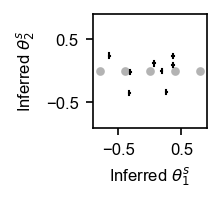

In [34]:
def plot_tsub(ax, tsub, tsub_samples, order=(0,1)):
    nsub, msub, _ = tsub.shape
    assert msub == 2
    i1, i2 = order
    
    for i in range(nsub):
        ts = tsub[i]
        
        plt.plot([ts[i1,0]-ts[i1,1], ts[i1,0]+ts[i1,1]], [ts[i2,0],ts[i2,0]], color='k', lw=1)
        plt.plot([ts[i1,0], ts[i1,0]], [ts[i2,0]-ts[i2,1],ts[i2,0]+ts[i2,1]], color='k', lw=1)
    
    plt.xlim(-0.9,0.9)
    plt.ylim(-0.9,0.9)
    plt.xticks([-0.5, 0.5])
    plt.yticks([-0.5, 0.5])
    plt.xlabel(r"Inferred $\theta^s_1$")
    plt.ylabel(r"Inferred $\theta^s_2$")
    ax.set_aspect('equal')
    
    plt.scatter(tsub_samples[:,i1], tsub_samples[:,i2], s=10, color='0.7', zorder=-1)
        
    
plt.figure(figsize=(1,1), dpi=150)
plot_tsub(plt.gca(), params.thetasub, tsubs, order=order)

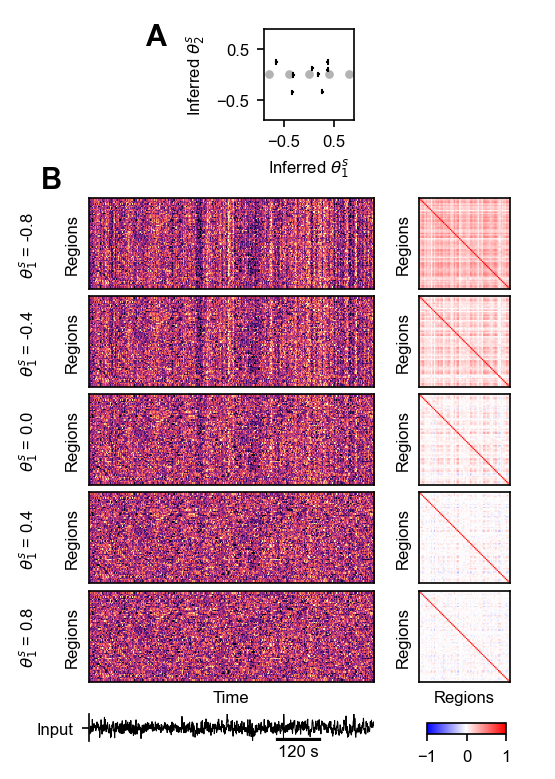

In [45]:
ind = 0
iparam = order[ind]
y, us, tsubs = param_sweep(iparam)


fig = plt.figure(figsize=(3.5,5), dpi=150)

gs = matplotlib.gridspec.GridSpec(9, 3, left=0.14, right=0.98, bottom=0.03, top=0.98, hspace=0.1, wspace=0.2,
                                 width_ratios=[1,1,1], height_ratios=[1,0.7,1,1,1,1,1,0.2,0.3]
                                 )

ax = plt.subplot(gs[0,1])
plot_tsub(ax, params.thetasub, tsubs, order=order)


ax = plt.subplot(gs[8,0:2])
plot_input(ax, us, dt=ds.t[1]-ds.t[0])


for i in range(n):
    plt.subplot(gs[i+2,0:2])
    plt.imshow(y[i], vmin=-2.5, vmax=2.5, cmap='magma', aspect='auto', interpolation='none')
    plt.xticks([])
    if i == n-1:
        plt.xlabel("Time")
    
    plt.xlim(0, 1200)
    plt.yticks([])
    plt.ylabel("Regions")
    plt.text(-200, nreg//2, f"$\\theta^s_{ind+1}$ = {tsubs[i,iparam]:.1f}", ha='right', va='center',
             fontsize=8, rotation='vertical')
    
    plt.subplot(gs[i+2,2])
    im = plt.imshow(np.corrcoef(y[i]), vmin=-1, vmax=1, cmap='bwr')
    plt.yticks([])
    plt.xticks([])
    plt.ylabel("Regions")
    if i == n-1:
        plt.xlabel("Regions")
        
# ax = plt.subplot(gs[8,2])
ax = fig.add_axes([0.785, 0.04, 0.15, 0.015])
plt.colorbar(im, cax=ax, orientation='horizontal')
# plot_input(ax, us, dt=ds.t[1]-ds.t[0])
        
bg = pu.Background(visible=False, spacing=1)    
bg.add_labels([0.25, 0.05], [0.95, 0.76], fontsize=14)


plt.savefig(f"./img/Fig_ParamEffectSub_{ind}.pdf")